In [1]:
import sympy as sym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import control
# from ipywidgets import interact

s = sym.symbols('s', complex=True)

tfin = 20
dt = 1/10


# Diseño de controladores mediante Lugar Geométrico de las Raíces



Se busca encontrar compensadores a partir de análisis del **Lugar Geométrico de las Raíces**.

Los compensadores se diseñan para que los procesos desarrollen tareas específicas cumpliendo con especificaciones del comportamiento en la respuesta transitoria (tiempo de estabilización, máxima sobreelongación, etc) y estacionaria (error de estado estable).



## Método

Se añaden polos y ceros (del compensador) a la función de transferencia del sistema en lazo directo $G(s)$, de manera que el **Lugar Geométrico de las Raíces** pase por los polos deseados en lazo cerrado. Una vez se garantiza que el **Lugar Geométrico de las Raíces** pasa por los polos deseados, se encuentra la ganancia del compensador que permite que el sistema en lazo cerrado se comporte según los polos deseados.

Tenga en cuenta que la función de transferencia de lazo cerrado, en un sistema controlado con realimentación unitaria, es:

$$G_{LC} = \frac{G(s)}{1+G(s)}$$

Los valores de $s$ que conforman el Lugar Geométrico de las Raíces cumplen que:

$$1+G(s) = 0$$

Que es equivalente a:

$$G(s) = -1$$

De donde se genera la condición de fase:

$$\angle G(s) = \pm 180 ^o$$

Y la condición de magnitud:

$$ | G(s) | = 1$$

### Compensador en adelanto

Los pasos para diseñar un compensador mediante el Lugar Geométrico de las Raíces son:

1. Determine la localización deseada para los polos dominantes en lazo cerrado.

2. A partir del Lugar Geométrico de las Raíces, determine si un ajuste de ganancia puede brindar el comportamiento deseado. Si no, encuentre el ángulo que debe aportar el compensador para que el Lugar Geométrico de las Raíces pase por los polos deseados.

3. Suponga la forma de un compensador 

$$ G_c(s) = k_c\frac{s+\frac{1}{T}}{s+\frac{1}{\alpha T}}$$

donde los parámetros $k_c$, $\alpha$ y $T$ se determinan a partir de los requisitos del sistema.

4. Encuentre $\alpha$ y $T$ para garanttizar que el Lugar Geométrico de las Raíces pase por los polos deseados con la condición de fase.

5. Encuentre $k_c$ a partir de la condición de magnitud.

**Ejemplo**

Suponga un proceso cuyo modelo es:

$$G_p(s) = \frac{4}{s\left ( s+2 \right )}$$

- ceros: Valores de $s$ que hacen que $4=0$.
- polos: Valores de $s$ que hacen que $s(s+2)=0 \rightarrow s=\{0,-2\}$

In [59]:
# Se define la función de transferencia del proceso
Gp = control.tf(4, [1,2,0])
Gp

TransferFunction(array([4]), array([1, 2, 0]))

$$G_{LC}(s)=\frac{G(s)}{1+G(s)}$$

$$G_{LC}(s)=\frac{\frac{4}{s\left ( s+2 \right )}}{1+\frac{4}{s\left ( s+2 \right )}}$$

Si se realimenta el sistema con un compensador $G_c(s)=1$

In [60]:
G_LC1 = control.feedback(1*Gp,1)
G_LC1

TransferFunction(array([4]), array([1, 2, 4]))

Los polos y ceros del sistema en lazo cerrado serían:

In [61]:
# Polos de lazo con Gc(s) = 1
pLC1 = G_LC1.pole()
pLC1

array([-1.+1.73205081j, -1.-1.73205081j])

In [62]:
# Ceros de lazo con Gc(s) = 1
cLC1 = G_LC1.zero()
cLC1

array([], dtype=float64)

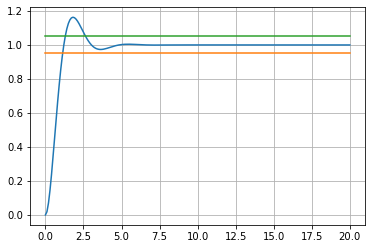

In [65]:
ts = np.linspace(0, tfin, round(tfin/dt))

_, yLC1 = control.step_response(G_LC1,ts)
plt.plot(ts,yLC1,
         ts,0.95*np.ones(len(ts)),
         ts,1.05*np.ones(len(ts)))
plt.grid()

Suponga que requiere disminuir el tiempo de estabilización a la mitad del que obtendría al realimenta con $G_c(s)=1$ manteniendo el amortiguamiento.

In [66]:
# Polos de lazo cerrado deseados
pLC_deseado = 2*pLC1
# pLC_deseado
# pLC_deseado = np.array([-2 + 2*1j,-2 - 2*1j])
pLC_deseado

array([-2.+3.46410162j, -2.-3.46410162j])

Se verifica si los polos deseados hacen parte del Lugar Geométrico de las Raíces.

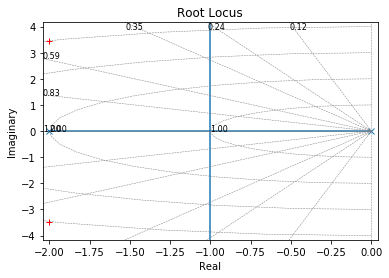

In [67]:
_,_ = control.root_locus(Gp,#FdT proceso
                         plot = True);
plt.plot(pLC_deseado.real, pLC_deseado.imag, 'r+')

Como los polos deseados no hacen parte del Lugar Geométrico de las Raíces, se define una forma de compensador.

$$ G_c(s) = k_c\frac{s+\frac{1}{T}}{s+\frac{1}{\alpha T}}$$

y la función de transferencia de lazo directo:

$$ G(s) = G_c(s)G_p(s)$$


In [68]:
G_p_sym = 4/(s**2+2*s)#FdT simbolica proceso
G_p_sym

4/(s**2 + 2*s)

Al evaluar la función de transferencia del proceso en los polos deseados se obtiene:

In [69]:
pLC_deseado

array([-2.+3.46410162j, -2.-3.46410162j])

In [70]:
#FdT proceso evaluada en un polo deseado
G_p_sym_des = G_p_sym.subs(s,pLC_deseado[0]).simplify()
G_p_sym_des 

-0.25 + 0.144337567297406*I

Este número complejo equivale a una magnitud

In [71]:
#norma de FdT proceso evaluada en un polo deseado

sym.Abs(G_p_sym_des)

0.288675134594813

y una fase

In [72]:
#fase de FdT proceso evaluada en un polo deseado

sym.arg(G_p_sym_des)

-0.523598775598299 + pi

La condición de fase indica que el compensador debe aportar un ángulo que lleve el ángulo completo a $\pm 180^o$, en este caso:


In [73]:
#angulo que debe aportar el compensador para cumplir cond. de fase
ang_comp = -(sym.arg(G_p_sym_des) - sym.pi)
ang_comp

0.523598775598299

por lo que se requiere un compensador.  Se propone usar 

$$ G_c(s) = k_c\frac{s+\frac{1}{T}}{s+\frac{1}{\alpha T}}$$


In [74]:
#FdT simbolica del compensador 

kc,T,alpha,beta = sym.symbols('k_c,T,alpha,beta', real=True,positive = True)


G_c_sym = kc*(s+1/T)/(s+1/(alpha*T))
G_c_sym

k_c*(s + 1/T)/(s + 1/(T*alpha))

El ángulo que aporta el compensador es:

In [75]:
sym.arg(G_c_sym.subs(s,pLC_deseado[0]).simplify())

arg((T*(-2.0 + 3.46410161513775*I) + 1)/(T*alpha*(-2.0 + 3.46410161513775*I) + 1))

Observe que tiene dos parámetros y una sola condición. En este caso se selecciona un parámetro de forma arbitraria para determinar el otro.

Una posible solución es ubicar el cero del compensador bajo el polo deseado.

El cero del compensador cumple:
$$s+\frac{1}{T} = 0$$
Como se desea en $s=-2$
$$-2+\frac{1}{T} = 0$$
$$T = \frac{1}{2}$$

cero del compensador en $s=-2.5$

$$-2.5 + \frac{1}{T} = 0$$
$$T = \frac{2}{5}$$

y se soluciona la condición de fase

In [100]:
# parametros = {T:1/2}
parametros = {T:1/1.9}
# parametros = {T:1/3}
# parametros = {T:1}

In [101]:
CondFase = sym.arg(G_c_sym.subs(s,pLC_deseado[0]).
                   subs(parametros)) - ang_comp
CondFase

arg((-0.1 + 3.46410161513775*I)/(-2.0 + 3.46410161513775*I + 1.9/alpha)) - 0.523598775598299

In [102]:

sym.solve(CondFase,alpha)


[0.491101694915254]

In [79]:
# parametros = {T:1/2, alpha:0.5}
parametros = {T:2/5, alpha:0.52884}
# parametros = {T:1/3, alpha:0.5357}
# parametros = {T:1, alpha:0.35}

In [80]:
#FdT simbolica del compensador con los parametros hasta el momento

G_c_sym.subs(parametros)

k_c*(s + 2.5)/(s + 4.72732773617729)

In [81]:
#FdT  del compensador para simular

# Gc = control.tf([1,2],[1,4])
Gc = control.tf([1,2.5],[1,4.727])
# Gc = control.tf([1,3],[1,5.6])
# Gc = control.tf([1,1],[1,2.86])
Gc

TransferFunction(array([1. , 2.5]), array([1.   , 4.727]))

In [82]:
G = Gc*Gp
G

TransferFunction(array([ 4., 10.]), array([1.   , 6.727, 9.454, 0.   ]))

In [83]:
G.pole()

array([-4.727, -2.   ,  0.   ])

El Lugar Geométrico de las Raíces del proceso y el compensador es:

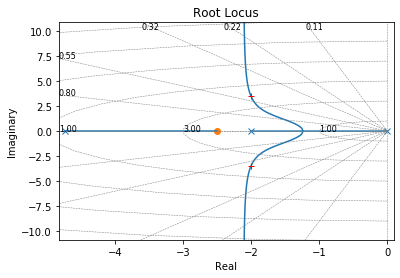

In [84]:
_,_ = control.root_locus(Gc*Gp,
                         plot = True);
plt.plot(pLC_deseado.real, pLC_deseado.imag, 'r+')

Ahora debe hallarse $k_c$ con la condición de magnitud.

Ya se ha calculado que la magnitud del proceso evaluado en el polo deseado es:

In [85]:
sym.Abs(G_p_sym_des)

0.288675134594813

Por lo que el compensador debe aportar una magnitud de:

In [27]:
# mag_comp * sym.Abs(G_p_sym_des) = 1


In [86]:
mag_comp = 1/sym.Abs(G_p_sym_des)
mag_comp
#magnitud que debe tener el compensador para cumplir cond.

3.46410161513776

In [87]:
sym.Abs(G_c_sym.subs(s,pLC_deseado[0]).
                   subs(parametros))/mag_comp - 1

0.229164897941241*k_c - 1

In [88]:
CondMag = sym.Abs(G_c_sym.subs(s,pLC_deseado[0]).
                   subs(parametros))/mag_comp - 1
sym.solve(CondMag,kc)

[4.36367004276722]

In [103]:
# parametros = {T:1/2, alpha:0.5, kc: 4}
parametros = {T:2/5, alpha:0.52884, kc: 4.3637}
# parametros = {T:1, alpha:0.35, kc: 3.43}

Y  el compensador es:

In [104]:
G_c_sym.subs(parametros)

4.3637*(s + 2.5)/(s + 4.72732773617729)

In [105]:
# Gc = 4*control.tf([1,2],[1,4])
Gc = 4.3637*control.tf([1,2.5],[1,4.727])
# Gc = 3.43*control.tf([1,1],[1,2.86])
Gc

TransferFunction(array([ 4.3637 , 10.90925]), array([1.   , 4.727]))

Verifique el comportamiento en el dominio del tiempo

**Respuesta al escalón del proceso sin compensador**


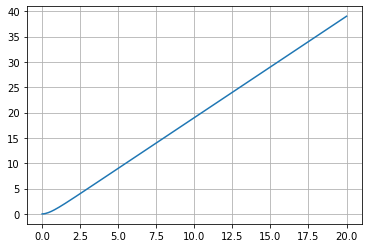

In [92]:


_, yLA = control.step_response(Gp, ts)
plt.plot(ts,yLA)
plt.grid()


**Respuesta al escalón del proceso realimentado**


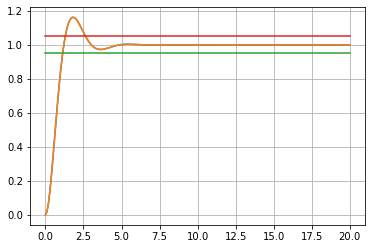

In [93]:

_, yLC1 = control.step_response(control.feedback(Gp,1),ts)
plt.plot(ts,yLC1)
plt.plot(ts,yLC1,
         ts,0.95*np.ones(len(ts)),
         ts,1.05*np.ones(len(ts)))
plt.grid()

**Respuesta al escalón del proceso con compensador**


In [94]:
control.feedback(Gc*Gp,1).pole()

array([-1.99988753+3.46424069j, -1.99988753-3.46424069j,
       -2.72722494+0.j        ])

In [95]:
control.feedback(Gc*Gp,1).zero()

array([-2.5])

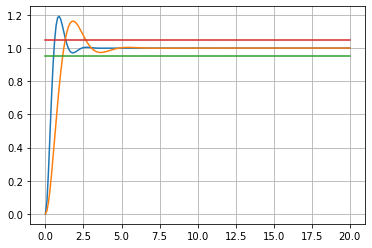

In [96]:

_, yLC = control.step_response(control.feedback(Gc*Gp,1),ts)
plt.plot(ts,yLC)
plt.plot(ts,yLC1,
         ts,0.95*np.ones(len(ts)),
         ts,1.05*np.ones(len(ts)))
plt.grid()

Puede compararse la respuesta del sistema solo realimentado con la respuesta del sistema compensado

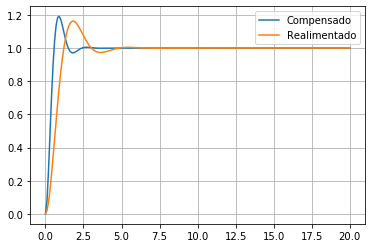

In [106]:
plt.plot(ts,yLC,ts,yLC1)
plt.legend(('Compensado','Realimentado'))
plt.grid()


## ¿Cómo se implementa el compensador?

$$G_c(s) = \frac{4s+8}{s+4}$$

$$G_c(s) = \frac{salida(s)}{entrada(s)}$$

$$G_c(s) = \frac{4s+8}{s+4} = \frac{salida_u}{entrada_e}$$

$$(4s+8)entrada_e = (s+4)salida_u$$

$$4s\cdot entrada_e+8entrada_e = s\cdot salida_u+4salida_u$$

$$4 \frac{de}{dt}+8e(t) = \frac{du}{dt}+4u(t)$$

$$ u(t) =  \frac{de}{dt}+2e(t) - 0.25 \frac{du}{dt}$$

$$4s\cdot entrada_e+8entrada_e = s\cdot salida_u+4salida_u$$

Observe que el sistema controlado tiene un **error de estado estale** nulo para una entrada escalón. ¿Qué ocurre si la referencia es una rampa?

(0, 5)

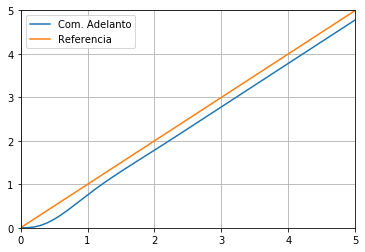

In [107]:

_, yLCr = control.step_response(control.feedback(Gc*Gp,1)*
                                control.tf(1,[1,0]),ts)
plt.plot(ts,yLCr)
plt.plot([ts[0],ts[-1]], [0,ts[-1]])
plt.legend(('Com. Adelanto','Referencia'))
plt.grid()
plt.xlim([0,5])
plt.ylim([0,5])

¿Cómo disminuir el error en estado estable sin afectar drásticamente la respuesta transitoria?

Suponga que entre los requerimientos también se encuentra "reducir" el error de estado estable ante una entrada más elaborada.  En este caso, se deben agregar dinámicas que no alteren de forma significativa al **LGDR** (porque ya se logró un requerimiento con el controlador en adelanto).

### Compensador en retardo

Los pasos para diseñar un compensador en retardo mediante el Lugar Geométrico de las Raíces son:

1. Suponga la forma de un compensador en retardo

$$ G_c(s) = k_c\frac{s+\frac{1}{T}}{s+\frac{1}{\beta T}}$$

donde los parámetros $k_c$, $T$ y $\beta$ se determinan a partir de los requisitos del sistema.

Observe que 

$$ \lim_{s\rightarrow 0}{G_c(s)} = k_c \cdot \beta$$

2. Encuentre la constante de error de estado estable especificada según los requerimientos.

3. Determine el incremento necesario en la constante de error estático.

4. Determine $T$ y $\beta$ apropiados para cumplir el incremento anterior sin alterar el **LGDR**.

5. Encuentre $k_c$ a partir de la condición de magnitud para ajustar la posición de los polos dominantes.

TransferFunction(array([17.4548, 43.637 ]), array([1.   , 6.727, 9.454, 0.   ]))

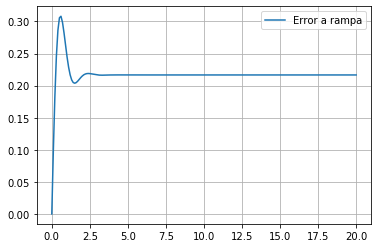

In [108]:
plt.plot(ts,ts-yLCr,
         label = 'Error a rampa')
plt.legend()
plt.grid()
Gc*Gp

De acuerdo con la gráfica anterior, el error de estado estable ante una entrada de velocidad es aproximadamente $0.25$. 

$$E_{ss}=\frac{1}{\lim_{\rightarrow 0}sG(s)}$$

In [109]:
Gc*Gp

TransferFunction(array([17.4548, 43.637 ]), array([1.   , 6.727, 9.454, 0.   ]))

In [111]:
9.454/43.64

0.21663611365719523

In [112]:
0.22/0.025

8.799999999999999

El error de estado estable ante la rampa puede disminuirse a $0.025$, por ejemplo. Para lograr esto, se selecciona $\beta = 10$, entonces el compensador en retardo es:


$$ k_c\frac{s+\frac{1}{T}}{s+\frac{1}{10 T}}$$

Como se requiere que el compensador no altere de manera significativa el **LGDR**, se toma $T$ de manera que su polo y cero estén "cercanos", por ejemplo $40$, por lo que el controlador es:

$$ k_c\frac{s+\frac{1}{40}}{s+\frac{1}{400}} = k_c\frac{s+0.025}{s+0.0025}$$


Verifique que el **LGDR** no se ha alterado significativamente

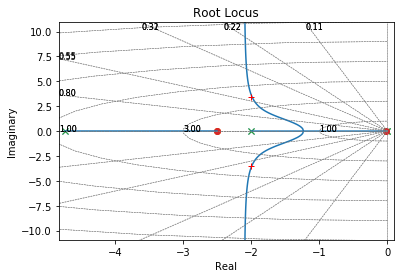

In [115]:
G_at = control.tf([1,0.025],[1,0.025/8.8])

_,_ = control.root_locus(Gc*Gp,plot = True);
_,_ = control.root_locus(G_at*Gc*Gp,plot = True);
plt.plot(pLC_deseado.real, pLC_deseado.imag, 'r+')

In [116]:
G_at_sym = kc*(s+1/T)/(s+1/(beta*T))
G_at_sym

k_c*(s + 1/T)/(s + 1/(T*beta))

In [117]:
parametros

{T: 0.4, alpha: 0.52884, k_c: 4.3637}

In [118]:
GLA_sym = (G_at_sym.subs({T:40,
                          beta:8.8})*
           G_c_sym.subs(parametros)*
           G_p_sym)
GLA_sym

17.4548*k_c*(s + 1/40)*(s + 2.5)/((s + 0.00284090909090909)*(s + 4.72732773617729)*(s**2 + 2*s))

In [119]:
sym.Abs(GLA_sym.subs(s,pLC_deseado[0])).simplify()

0.997250486583774*k_c

In [120]:
kc/sym.Abs(GLA_sym.subs(s,pLC_deseado[0])).simplify()

1.00275709408340

El compensador en atraso será entonces:

$$  1.00280668\frac{s+0.025}{s+0.0025}$$



El sistema compensado completo es:

In [121]:
G_at = 1.002757*control.tf([1,0.0025],[1,0.0025/8.8])
G = G_at*Gc*Gp
G

TransferFunction(array([17.50292288, 43.80106452,  0.10939327]), array([1.00000000e+00, 6.72728409e+00, 9.45591108e+00, 2.68579545e-03,
       0.00000000e+00]))

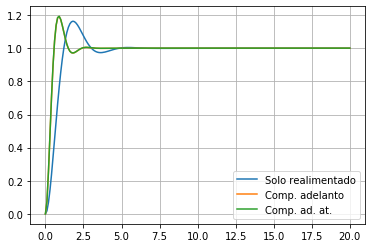

In [122]:

_, yLC_aa = control.step_response(control.feedback(G_at*Gc*Gp,1),ts)
plt.plot(ts,yLC1,
         ts,yLC,
         ts,yLC_aa)
plt.legend(('Solo realimentado','Comp. adelanto','Comp. ad. at.'))
plt.grid()


In [52]:
len(yLCr)

200

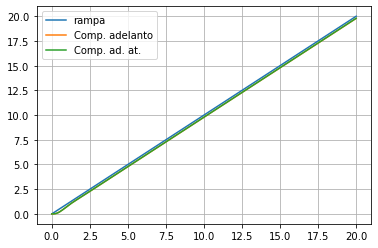

In [125]:
## Respuestas ante la rampa 
_, yLC_aar = control.step_response(control.feedback(G_at*Gc*Gp,1)*
                                  control.tf(1,[1,0]),ts)
plt.plot(ts,ts,
         ts,yLCr,
         ts,yLC_aar)
plt.legend(('rampa','Comp. adelanto','Comp. ad. at.'))
plt.grid()


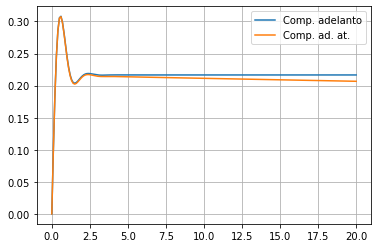

In [126]:
## error ante la rampa

plt.plot(ts,ts-yLCr,
         ts,ts-yLC_aar)
plt.legend(('Comp. adelanto','Comp. ad. at.'))
plt.grid()

-----------------------
**Ejercicio 1**

Considere el proceso modelado por

$$G_p(s) =  \frac{5}{s(s+4)(s+10)}$$

Encuentre un compensador para que los polos dominantes en lazo cerrado estén en $-3 \pm j3$

- No es necesario poner un cero bajo el polo deseado.
- Pruebe poniendo el cero a la derecha (valor real mayor) del polo deseado.
- Pruebe poniendo el cero a la izquierda (valor real menor) del polo deseado.
- Disminuya a la mitad el error de estado estable ante la rampa.

**Ejercicio 2**

Revise el contenido de la siguiente URL.
[https://homes.esat.kuleuven.be/~tokka/daisydata.html](https://homes.esat.kuleuven.be/~tokka/daisydata.html)

Analice los datos del proceso **dryer**

¿cómo puede hallar un modelo para el proceso?
- Diseñe un compesador para mejorar el funcionamiento del sistema

In [13]:
import pandas as pd
from scipy.signal import medfilt

datos = pd.read_csv("Datos/dryer.dat",sep="\t",header = None)
ts = 20



In [49]:
Entrada = list(datos[0]-datos[0].mean())
Salida = list(medfilt(list(datos[1]-datos[1].mean()), kernel_size=5))
tiempo = list(range(0,ts*(len(Entrada)),ts))


(2500, 3500)

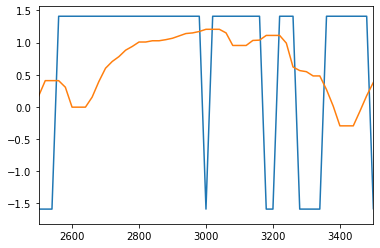

In [65]:
plt.plot(tiempo,Entrada,tiempo,Salida)
plt.xlim([2500,3500])

In [66]:
n = len(Entrada)
Entrada_1 = Entrada.copy()
Entrada_1.insert(0, 0)
Entrada_m1 = Entrada.copy()
Entrada_m1.insert(-1, 0)


Entrada_2 = Entrada_1.copy()
Entrada_2.insert(0, 0)
Entrada_3 = Entrada_2.copy()
Entrada_3.insert(0, 0)
Entrada_4 = Entrada_3.copy()
Entrada_4.insert(0, 0)

Entrada_m2 = Entrada_m1.copy()
Entrada_m2.insert(-1, 0)

Salida_1 = Salida.copy()
Salida_1.insert(0, 0)
Salida_m1 = Salida.copy()
Salida_m1.insert(-1, 0)


Salida_2 = Salida_1.copy()
Salida_2.insert(0, 0)
Salida_m2 = Salida_m1.copy()
Salida_m2.insert(-1, 0)

df = pd.DataFrame(np.transpose(np.array([tiempo,
                                         Entrada_m2[2:n+2],
                                         Entrada_m1[1:n+1],
                                         Entrada[0:n],
                                         Entrada_1[0:n],
                                         Entrada_2[0:n],
                                         Entrada_3[0:n],
                                         Entrada_4[0:n],
                                         Salida_m2[2:n+2],
                                         Salida_m1[1:n+1],
                                         Salida[0:n],
                                         Salida_1[0:n],
                                         Salida_2[0:n]])),
                  columns=['t',
                           'Um2',
                           'Um1',
                           'U',
                           'U1',
                           'U2',
                           'U3',
                           'U4',
                           'Ym2',
                           'Ym1',
                           'Y',
                           'Y1',
                           'Y2'])

df["dUdt"] = (df["Um1"]-df["U1"])/(ts*2)
df["dYdt"] = (df["Ym1"]-df["Y1"])/(ts*2)

df


,t,Um2,Um1,U,U1,U2,U3,U4,Ym2,Ym1,Y,Y1,Y2,dUdt,dYdt
0,0.0,1.41,-1.59,1.41,0.00,0.00,0.00,0.00,-0.050741,-0.050741,-0.050741,0.000000,0.000000,-0.03975,-0.001269
1,20.0,1.41,1.41,-1.59,1.41,0.00,0.00,0.00,0.112879,-0.050741,-0.050741,-0.050741,0.000000,0.00000,0.000000
2,40.0,1.41,1.41,1.41,-1.59,1.41,0.00,0.00,0.127529,0.112879,-0.050741,-0.050741,-0.050741,0.07500,0.004090
3,60.0,1.41,1.41,1.41,1.41,-1.59,1.41,0.00,0.166599,0.127529,0.112879,-0.050741,-0.050741,0.00000,0.004457
4,80.0,1.41,1.41,1.41,1.41,1.41,-1.59,1.41,0.264279,0.166599,0.127529,0.112879,-0.050741,0.00000,0.001343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,19900.0,1.41,1.41,1.41,1.41,-1.59,-1.59,-1.59,-0.744261,-0.744261,-0.744261,-0.475641,-0.185051,0.00000,-0.006715
996,19920.0,1.41,1.41,1.41,1.41,1.41,-1.59,-1.59,-0.517161,-0.744261,-0.744261,-0.744261,-0.475641,0.00000,0.000000
997,19940.0,0.00,1.41,1.41,1.41,1.41,1.41,-1.59,0.000000,-0.517161,-0.744261,-0.744261,-0.744261,0.00000,0.005678
998,19960.0,0.00,0.00,1.41,1.41,1.41,1.41,1.41,0.000000,0.000000,-0.517161,-0.744261,-0.744261,-0.03525,0.018607


$$y(t)=au(t)+b\frac{du}{dt}+c\frac{d^2u}{dt^2}+c\frac{dy}{dt}+d\frac{d^2y}{dt^2}$$

In [79]:

import statsmodels.formula.api as smf
# hipo1 = """Y ~ U4 + dYdt + dUdt + 1"""
hipo1 = """Y ~ U2 + Y1 + Y2"""
mod1 = smf.ols(formula= hipo1 , data=df).fit()
print(mod1.summary())




                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                 2.225e+04
Date:                Thu, 03 Nov 2022   Prob (F-statistic):               0.00
Time:                        00:12:19   Log-Likelihood:                 895.48
No. Observations:                1000   AIC:                            -1783.
Df Residuals:                     996   BIC:                            -1763.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0003      0.003      0.100      0.9

In [74]:
df.shape

(1000, 15)